In [1]:
import torch
import pandas as pd
#from google.colab import drive
import tarfile
import os
from PIL import Image
import clip
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# refs(umd).p

In [2]:
import pickle

# file_path = 'drive/My Drive/Deep Learning Project/refcocog/refcocog/annotations/refs(umd).p'
file_path = 'refcocog/annotations/refs(umd).p'

file = open(file_path, 'rb')

# Load pickle data
data = pickle.load(file)

# close the file
file.close()

In [3]:
train_data = list(filter(lambda img: img['split'] == 'train', data))
test_data = list(filter(lambda img: img['split'] == 'test', data))
val_data = list(filter(lambda img: img['split'] == 'val', data))

In [4]:
len(data)

49822

In [5]:
len(train_data), len(test_data), len(val_data)

(42226, 5023, 2573)

In [6]:
len(train_data) + len(test_data) + len(val_data) == len(data)

True

In [7]:
# The same image is referenced more than once because it has different referring expressions.
list(filter(lambda img: img['image_id'] == data[420]['image_id'], data))

[{'image_id': 359865,
  'split': 'test',
  'sentences': [{'tokens': ['a',
     'half',
     'of',
     'a',
     'sandwich',
     'on',
     'the',
     'far',
     'right',
     'side',
     'of',
     'a',
     'blue',
     'plate'],
    'raw': 'A half of a sandwich on the far right side of a blue plate.',
    'sent_id': 9440,
    'sent': 'a half of a sandwich on the far right side of a blue plate'}],
  'file_name': 'COCO_train2014_000000359865_313186.jpg',
  'category_id': 54,
  'ann_id': 313186,
  'sent_ids': [9440],
  'ref_id': 420},
 {'image_id': 359865,
  'split': 'test',
  'sentences': [{'tokens': ['the',
     'sandwich',
     'half',
     'in',
     'the',
     'center',
     'of',
     'the',
     'plate'],
    'raw': 'The sandwich half in the center of the plate.',
    'sent_id': 60301,
    'sent': 'the sandwich half in the center of the plate'},
   {'tokens': ['hoggie',
     'sandwich',
     'that',
     'is',
     'closest',
     'to',
     'purple',
     'bowl'],
    'raw

In [8]:
data[0]

{'image_id': 380440,
 'split': 'test',
 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'],
   'raw': 'the man in yellow coat',
   'sent_id': 8,
   'sent': 'the man in yellow coat'},
  {'tokens': ['skiier', 'in', 'red', 'pants'],
   'raw': 'Skiier in red pants.',
   'sent_id': 9,
   'sent': 'skiier in red pants'}],
 'file_name': 'COCO_train2014_000000380440_491042.jpg',
 'category_id': 1,
 'ann_id': 491042,
 'sent_ids': [8, 9],
 'ref_id': 0}

In [9]:
data[2]

{'image_id': 478885,
 'split': 'test',
 'sentences': [{'tokens': ['a', 'apple', 'desktop', 'computer'],
   'raw': 'A apple desktop computer',
   'sent_id': 14,
   'sent': 'a apple desktop computer'},
  {'tokens': ['the',
    'white',
    'imac',
    'computer',
    'that',
    'is',
    'also',
    'turned',
    'on'],
   'raw': 'the white IMac computer that is also turned on',
   'sent_id': 15,
   'sent': 'the white imac computer that is also turned on'}],
 'file_name': 'COCO_train2014_000000478885_124383.jpg',
 'category_id': 72,
 'ann_id': 124383,
 'sent_ids': [14, 15],
 'ref_id': 2}

In [10]:
grouped_images = {}
for img in data:
    grouped_images[img['image_id']] = {}

len(grouped_images)

25799

# Instances.json

In [11]:
import json

file_path = 'refcocog/annotations/instances.json'

file = open(file_path, 'rb')

instances = json.load(file)

file.close()

In [12]:
instances

{'info': {'description': 'This is stable 1.0 version of the 2014 MS COCO dataset.',
  'url': 'http://mscoco.org',
  'version': '1.0',
  'year': 2014,
  'contributor': 'Microsoft COCO group',
  'date_created': '2015-01-27 09:11:52.357475'},
 'images': [{'license': 1,
   'file_name': 'COCO_train2014_000000131074.jpg',
   'coco_url': 'http://mscoco.org/images/131074',
   'height': 428,
   'width': 640,
   'date_captured': '2013-11-21 01:03:06',
   'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg',
   'id': 131074},
  {'license': 3,
   'file_name': 'COCO_train2014_000000524291.jpg',
   'coco_url': 'http://mscoco.org/images/524291',
   'height': 426,
   'width': 640,
   'date_captured': '2013-11-18 09:59:07',
   'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg',
   'id': 524291},
  {'license': 7,
   'file_name': 'COCO_train2014_000000524297.jpg',
   'coco_url': 'http://mscoco.org/images/524297',
   'height': 446,
   'width': 640,
   '

In [13]:
instances.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [14]:
len(instances['images'])

25799

In [15]:
instances['images'][1]

{'license': 3,
 'file_name': 'COCO_train2014_000000524291.jpg',
 'coco_url': 'http://mscoco.org/images/524291',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 09:59:07',
 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg',
 'id': 524291}

In [16]:
# Checking for correspondence between the
# id in instances and the id in the pickle
list(filter(lambda img: img['image_id'] == 524291, data))

[{'image_id': 524291,
  'split': 'train',
  'sentences': [{'tokens': ['a',
     'black',
     'and',
     'white',
     'dog',
     'laying',
     'down',
     ',',
     'looking',
     'away',
     'from',
     'the',
     'camera'],
    'raw': 'A black and white dog laying down, looking away from the camera.',
    'sent_id': 92321,
    'sent': 'a black and white dog laying down , looking away from the camera'},
   {'tokens': ['a',
     'black',
     'and',
     'white',
     'dog',
     'looks',
     'away',
     'into',
     'a',
     'field'],
    'raw': 'A black and white dog looks away into a field.',
    'sent_id': 92322,
    'sent': 'a black and white dog looks away into a field'}],
  'file_name': 'COCO_train2014_000000524291_16521.jpg',
  'category_id': 18,
  'ann_id': 16521,
  'sent_ids': [92321, 92322],
  'ref_id': 40504},
 {'image_id': 524291,
  'split': 'train',
  'sentences': [{'tokens': ['standing', 'dog'],
    'raw': 'standing dog',
    'sent_id': 46507,
    'sent': 'st

In [17]:
len(instances['categories']), instances['categories']

(80,
 [{'supercategory': 'person', 'id': 1, 'name': 'person'},
  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
  {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
  {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
  {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
  {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
  {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
  {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
  {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
  {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
  {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
  {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
  {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
  {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
  {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
  {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
  {'supercategory': 'animal', 'id

In [18]:
len(instances['annotations'])

208960

In [19]:
instances['annotations'][0]

{'segmentation': [[21.11,
   239.09,
   16.31,
   274.6,
   198.65,
   349.45,
   240.87,
   336.98,
   320.52,
   293.79,
   334.91,
   248.69,
   357.95,
   273.64,
   353.15,
   289.0,
   398.25,
   267.88,
   437.6,
   251.57,
   412.65,
   228.54,
   240.87,
   210.31,
   219.76,
   141.21,
   113.24,
   153.69,
   63.34,
   156.57,
   26.87,
   169.04]],
 'area': 48667.84089999999,
 'iscrowd': 0,
 'image_id': 131074,
 'bbox': [16.31, 141.21, 421.29, 208.24],
 'category_id': 65,
 'id': 318235}

In [20]:
len(list(filter(lambda img: img['image_id'] == 131074, data)))

1

In [21]:
ids = {}
for annotation in instances['annotations']:
    ids[annotation['id']] = {}

len(ids)

208960

# Bounding Box Visualization

## 1. Find a match between image, annotation and text prompt

In [22]:
instances['annotations'][0]

{'segmentation': [[21.11,
   239.09,
   16.31,
   274.6,
   198.65,
   349.45,
   240.87,
   336.98,
   320.52,
   293.79,
   334.91,
   248.69,
   357.95,
   273.64,
   353.15,
   289.0,
   398.25,
   267.88,
   437.6,
   251.57,
   412.65,
   228.54,
   240.87,
   210.31,
   219.76,
   141.21,
   113.24,
   153.69,
   63.34,
   156.57,
   26.87,
   169.04]],
 'area': 48667.84089999999,
 'iscrowd': 0,
 'image_id': 131074,
 'bbox': [16.31, 141.21, 421.29, 208.24],
 'category_id': 65,
 'id': 318235}

In [23]:
ann_ids = []
for image in data:
    ann_ids.append(image['ann_id'])
len(ann_ids)

49822

In [24]:
# This is the same as the following cell, however it basically takes
# an infinite amount of time to run (~30 seconds / 1000 images)
# It would take ~25 minutes to match all the annotations to their respective
# images this way

# match_count = 0
# for index, img in enumerate(data):
#     matches = list(filter(lambda ann: ann['id'] == img['ann_id'], instances['annotations']))
#     match_count += len(matches)

#     if index % 1000 == 0:
#         print(f'Images processed: {index}')

# print(f'There are {match_count} matches')

In [25]:
instances['images']

[{'license': 1,
  'file_name': 'COCO_train2014_000000131074.jpg',
  'coco_url': 'http://mscoco.org/images/131074',
  'height': 428,
  'width': 640,
  'date_captured': '2013-11-21 01:03:06',
  'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg',
  'id': 131074},
 {'license': 3,
  'file_name': 'COCO_train2014_000000524291.jpg',
  'coco_url': 'http://mscoco.org/images/524291',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-18 09:59:07',
  'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg',
  'id': 524291},
 {'license': 7,
  'file_name': 'COCO_train2014_000000524297.jpg',
  'coco_url': 'http://mscoco.org/images/524297',
  'height': 446,
  'width': 640,
  'date_captured': '2013-11-18 11:56:12',
  'flickr_url': 'http://farm4.staticflickr.com/3007/2552566879_0822a21ede_z.jpg',
  'id': 524297},
 {'license': 4,
  'file_name': 'COCO_train2014_000000393228.jpg',
  'coco_url': 'http://mscoco.org/images/393228',
  'height': 427,
  

In [26]:
# This version takes ~0.1 seconds to run

matches = {}

images_actual_file_names = {}
for image in instances['images']:
    images_actual_file_names[image['id']] = image['file_name']

for image in data:
    if image['ann_id'] not in matches:
        matches[image['ann_id']] = {}

    matches[image['ann_id']]['image'] = image
    matches[image['ann_id']]['image']['actual_file_name'] = images_actual_file_names[image['image_id']]

for annotation in instances['annotations']:
    if annotation['id'] not in matches:
        continue

    # if 'annotation' not in matches[annotation['id']]:
    #     matches[annotation['id']]['annotation'] = []

    # matches[annotation['id']]['annotation'].append(annotation)

    matches[annotation['id']]['annotation'] = annotation

In [27]:
# Just checking the matching was unique
# For this to work, the previous cell should create an array of annotations for
# each match (using currently commented code)
# Otherwise, it prints 7, as it is the number of keys inside each annotation

for match in matches:
    l = len(matches[match]['annotation'])
    if l > 1:
        print(l)

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [28]:
len(matches)

49820

In [29]:
matches

{491042: {'image': {'image_id': 380440,
   'split': 'test',
   'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'],
     'raw': 'the man in yellow coat',
     'sent_id': 8,
     'sent': 'the man in yellow coat'},
    {'tokens': ['skiier', 'in', 'red', 'pants'],
     'raw': 'Skiier in red pants.',
     'sent_id': 9,
     'sent': 'skiier in red pants'}],
   'file_name': 'COCO_train2014_000000380440_491042.jpg',
   'category_id': 1,
   'ann_id': 491042,
   'sent_ids': [8, 9],
   'ref_id': 0,
   'actual_file_name': 'COCO_train2014_000000380440.jpg'},
  'annotation': {'segmentation': [[386.14,
     222.22,
     397.97,
     158.85,
     436.84,
     158.85,
     422.47,
     133.5,
     406.42,
     158.85,
     382.76,
     143.64,
     374.31,
     140.26,
     378.53,
     137.73,
     399.66,
     130.12,
     418.25,
     110.69,
     405.57,
     87.03,
     411.49,
     73.51,
     423.32,
     65.06,
     443.6,
     100.55,
     462.18,
     97.17,
     464.72,
     111

### 1.1 Computing how many expression there are on average

In [30]:
# Number of distinct images
images_count = len(instances['images'])

# Number of distinct prompts
prompts_count = np.array([len(matches[match]['image']['sentences']) for match in matches]).sum()

# Average number of referring expression per DISTINCT image
prompts_count / images_count

3.682584596302182

## 2. Display image, prompt and bounding box

[Add the bounding box onto the image](https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image)

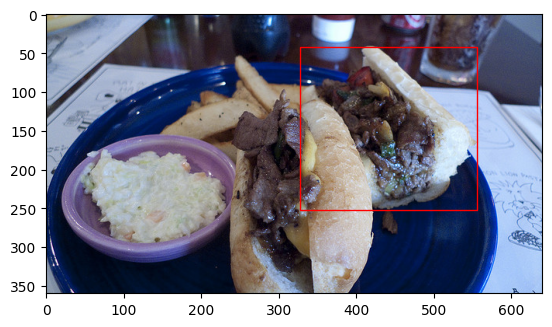

A half of a sandwich on the far right side of a blue plate.
{'image_id': 359865, 'split': 'test', 'sentences': [{'tokens': ['a', 'half', 'of', 'a', 'sandwich', 'on', 'the', 'far', 'right', 'side', 'of', 'a', 'blue', 'plate'], 'raw': 'A half of a sandwich on the far right side of a blue plate.', 'sent_id': 9440, 'sent': 'a half of a sandwich on the far right side of a blue plate'}], 'file_name': 'COCO_train2014_000000359865_313186.jpg', 'category_id': 54, 'ann_id': 313186, 'sent_ids': [9440], 'ref_id': 420, 'actual_file_name': 'COCO_train2014_000000359865.jpg'}


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

folder_path = 'refcocog/images/'

# First image in the dataset
test_sample = matches[list(matches.keys())[420]]

# Loading the image
img = Image.open(folder_path + test_sample['image']['actual_file_name'])

# Preparing the output
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
bounding_box_coordinates = test_sample['annotation']['bbox']
top_left_x, top_left_y = bounding_box_coordinates[0], bounding_box_coordinates[1]
width, height = bounding_box_coordinates[2], bounding_box_coordinates[3]

# Parameters: (x, y), width, height
rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Display prompt
print(test_sample['image']['sentences'][0]['raw'])
print(test_sample['image'])

In [32]:
list(filter(lambda img: img['image_id'] == 359865, data))

[{'image_id': 359865,
  'split': 'test',
  'sentences': [{'tokens': ['a',
     'half',
     'of',
     'a',
     'sandwich',
     'on',
     'the',
     'far',
     'right',
     'side',
     'of',
     'a',
     'blue',
     'plate'],
    'raw': 'A half of a sandwich on the far right side of a blue plate.',
    'sent_id': 9440,
    'sent': 'a half of a sandwich on the far right side of a blue plate'}],
  'file_name': 'COCO_train2014_000000359865_313186.jpg',
  'category_id': 54,
  'ann_id': 313186,
  'sent_ids': [9440],
  'ref_id': 420,
  'actual_file_name': 'COCO_train2014_000000359865.jpg'},
 {'image_id': 359865,
  'split': 'test',
  'sentences': [{'tokens': ['the',
     'sandwich',
     'half',
     'in',
     'the',
     'center',
     'of',
     'the',
     'plate'],
    'raw': 'The sandwich half in the center of the plate.',
    'sent_id': 60301,
    'sent': 'the sandwich half in the center of the plate'},
   {'tokens': ['hoggie',
     'sandwich',
     'that',
     'is',
     'c